# imports 

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns


# load data

In [2]:
data = pd.read_csv('../data/final_dataset_english_only.csv')

# Polarity via Divergence Similarity (1 − JSD)
#### no filter

Top 5 genres with highest polarity (similar pos/neg distributions):
                    genre  polarity  n_comments
23     brutal death metal  0.979529        1116
180                   rap  0.975426        1723
72   experimental hip hop  0.975037        1964
150                 noise  0.972270        1045
96                  grime  0.971467        1587 

Bottom 5 genres with lowest polarity (dissimilar distributions):
           genre  polarity  n_comments
231        world  0.726268         703
227   vocal jazz  0.711740        1346
144      new age  0.694056        1102
195  smooth jazz  0.688407        1995
232      worship  0.674584        1926


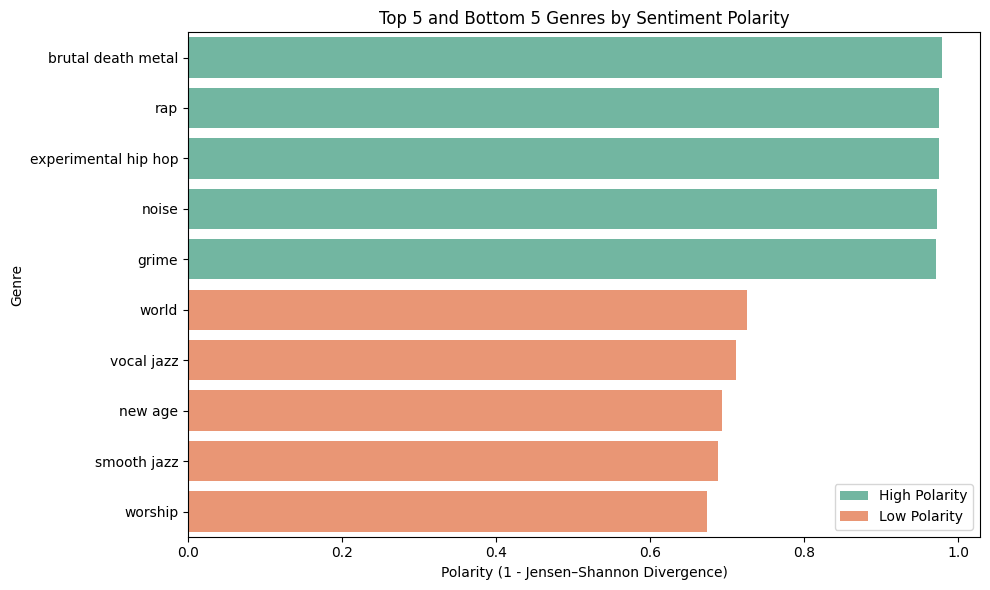

233


In [34]:
MIN_COMMENTS = 500  
BINS = np.linspace(0, 1, 21) 

for col in ["vader_pos", "vader_neg"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

sent_data = data.dropna(subset=["vader_pos", "vader_neg", "genre"])

results = []

for genre, subset in sent_data.groupby("genre"):
    if len(subset) < MIN_COMMENTS:
        continue

    pos_hist, _ = np.histogram(subset["vader_pos"], bins=BINS)
    neg_hist, _ = np.histogram(subset["vader_neg"], bins=BINS)

    if pos_hist.sum() > 0 and neg_hist.sum() > 0:
        pos_prob = pos_hist / pos_hist.sum()
        neg_prob = neg_hist / neg_hist.sum()

        jsd = jensenshannon(pos_prob, neg_prob, base=2) ** 2

        polarity = 1 - jsd

        results.append((genre, polarity, len(subset)))

polarity_df = pd.DataFrame(results, columns=["genre", "polarity", "n_comments"])
polarity_df = polarity_df.sort_values("polarity", ascending=False)  
top5 = polarity_df.head(5) 
bottom5 = polarity_df.tail(5) 


print("Top 5 genres with highest polarity (similar pos/neg distributions):")
print(top5, "\n")
print("Bottom 5 genres with lowest polarity (dissimilar distributions):")
print(bottom5)

plt.figure(figsize=(10, 6))
plot_df = pd.concat([top5, bottom5])

sns.barplot(
    data=plot_df,
    x="polarity", y="genre",
    hue=np.where(plot_df["polarity"] >= 0.8, "High Polarity", "Low Polarity"),
    dodge=False, palette="Set2"
)

plt.xlabel("Polarity (1 - Jensen–Shannon Divergence)")
plt.ylabel("Genre")
plt.title("Top 5 and Bottom 5 Genres by Sentiment Polarity")
plt.tight_layout()
plt.savefig("plots/general_statistics/genre_sentiment_polarity_approach1.png", dpi=300)
plt.show()

print(len(polarity_df))
polarity_df_approach1 = polarity_df

In [23]:
polarity_df_filtered = polarity_df[polarity_df["polarity"] > 0.8]
print(len(polarity_df))
print(len(polarity_df_filtered))

233
195


In [27]:
top5_a1 = ["brutal death metal", "rap", "experimental hip hop", "noise", "grime"]
bottom5_a1 = ["world", "vocal jazz", "new age", "smooth jazz", "worship"]
combined_ai1 = top5_a1 + bottom5_a1

# Polarity via Divergence Similarity (1 − JSD)
#### two step filter

Top 5 genres with highest polarity (similar pos/neg distributions):
                    genre  polarity  n_comments
19     brutal death metal  0.960040         695
35            death metal  0.954331         600
64   experimental hip hop  0.943126        1042
157                   rap  0.938162         872
129                 noise  0.933480         559 

Bottom 5 genres with lowest polarity (dissimilar distributions):
                  genre  polarity  n_comments
20               celtic  0.475390         970
187         talent show  0.474318         894
152  progressive trance  0.468731        1179
204             worship  0.451238        1379
170         smooth jazz  0.397050        1315


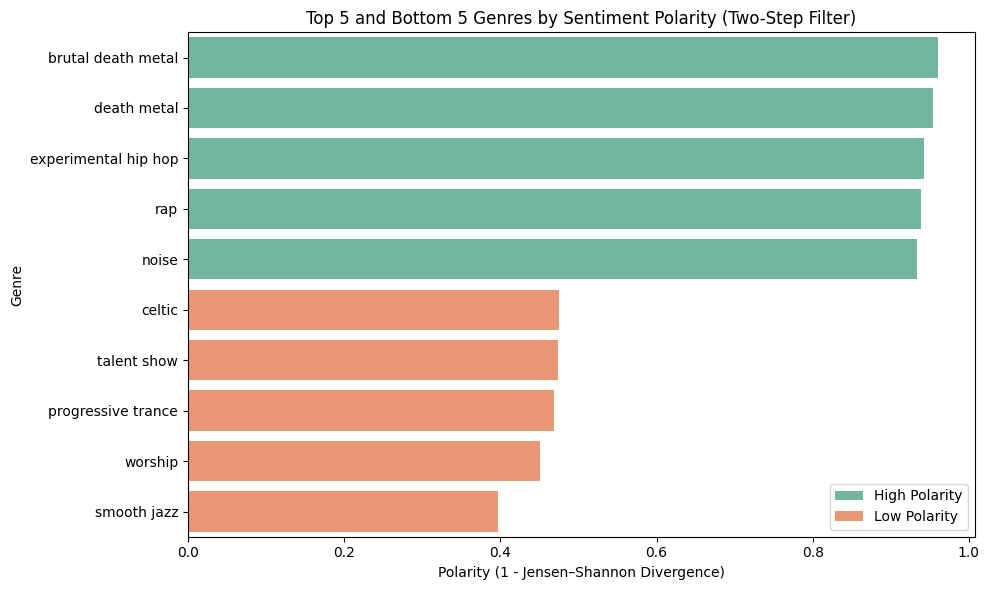

205


In [35]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
MIN_COMMENTS = 500        # minimum total comments per genre
MIN_VALID = 100           # minimum valid pos/neg comments after thresholding
SENT_THRESHOLD = 0.2      # threshold for considering a comment positive/negative
BINS = np.linspace(0, 1, 21)  # 20 bins between 0 and 1

# Ensure numeric
for col in ["vader_pos", "vader_neg"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Drop missing
sent_data = data.dropna(subset=["vader_pos", "vader_neg", "genre"])

results = []

# Compute polarity per genre
for genre, subset in sent_data.groupby("genre"):
    if len(subset) < MIN_COMMENTS:
        continue

    # Step 1: filter out neutral comments
    valid_subset = subset[
        (subset["vader_pos"] >= SENT_THRESHOLD) | (subset["vader_neg"] >= SENT_THRESHOLD)
    ]

    # Step 2: require enough valid pos/neg comments
    if (valid_subset["vader_pos"] >= SENT_THRESHOLD).sum() < MIN_VALID:
        continue
    if (valid_subset["vader_neg"] >= SENT_THRESHOLD).sum() < MIN_VALID:
        continue

    # Build histograms
    pos_hist, _ = np.histogram(valid_subset["vader_pos"], bins=BINS)
    neg_hist, _ = np.histogram(valid_subset["vader_neg"], bins=BINS)

    if pos_hist.sum() > 0 and neg_hist.sum() > 0:
        pos_prob = pos_hist / pos_hist.sum()
        neg_prob = neg_hist / neg_hist.sum()

        jsd = jensenshannon(pos_prob, neg_prob, base=2) ** 2
        polarity = 1 - jsd

        results.append((genre, polarity, len(valid_subset)))

polarity_df = pd.DataFrame(results, columns=["genre", "polarity", "n_comments"])
polarity_df = polarity_df.sort_values("polarity", ascending=False)  # reassign

top5 = polarity_df.head(5)   # now correct: top 5 highest
bottom5 = polarity_df.tail(5)  # now correct: bottom 5 lowest

print("Top 5 genres with highest polarity (similar pos/neg distributions):")
print(top5, "\n")
print("Bottom 5 genres with lowest polarity (dissimilar distributions):")
print(bottom5)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plot_df = pd.concat([top5, bottom5])

sns.barplot(
    data=plot_df,
    x="polarity", y="genre",
    hue=np.where(plot_df["polarity"] >= 0.8, "High Polarity", "Low Polarity"),
    dodge=False, palette="Set2"
)

plt.xlabel("Polarity (1 - Jensen–Shannon Divergence)")
plt.ylabel("Genre")
plt.title("Top 5 and Bottom 5 Genres by Sentiment Polarity (Two-Step Filter)")
plt.tight_layout()
plt.savefig("plots/general_statistics/genre_sentiment_polarity_approach2.png", dpi=300)
plt.show()
print(len(polarity_df))
polarity_df_approach2 = polarity_df

In [36]:
# Sort Approach 1 results by polarity to get the ranking
a1_sorted = polarity_df_approach1.sort_values("polarity", ascending=False).reset_index(drop=True)

missing = []
for rank, row in a1_sorted.iterrows():
    genre = row["genre"]
    if genre not in polarity_df_approach2["genre"].values:
        missing.append((genre, rank + 1))  # +1 for human-readable rank
    if len(missing) >= 5:
        break

print("Top 5 genres from Approach 1 that are missing in Approach 2:")
for genre, rank in missing:
    print(f"{genre} (rank {rank} in Approach 1)")


Top 5 genres from Approach 1 that are missing in Approach 2:
funk (rank 68 in Approach 1)
baroque (rank 128 in Approach 1)
atmospheric black metal (rank 137 in Approach 1)
lounge (rank 141 in Approach 1)
j-rock (rank 150 in Approach 1)


In [46]:
def compute_rank_changes(polarity_df1, polarity_df2, top_n=10):
    # Rank genres within each approach
    df1 = polarity_df1.copy()
    df2 = polarity_df2.copy()
    df1["rank1"] = df1["polarity"].rank(ascending=False, method="min").astype(int)
    df2["rank2"] = df2["polarity"].rank(ascending=False, method="min").astype(int)

    # Merge on genre, keeping also n_comments from both approaches
    merged = df1.merge(
        df2[["genre", "rank2", "n_comments"]],
        on="genre",
        how="left",
        suffixes=("_before", "_after")
    )

    # Compute Δrank (positive = moved down, negative = moved up)
    merged["delta_rank"] = merged["rank2"] - merged["rank1"]

    # Top and bottom genres from Approach 1
    top1 = merged.nsmallest(top_n, "rank1")
    bottom1 = merged.nlargest(top_n, "rank1")

    return top1[["genre", "rank1", "rank2", "delta_rank", "n_comments_before", "n_comments_after"]], \
           bottom1[["genre", "rank1", "rank2", "delta_rank", "n_comments_before", "n_comments_after"]]

top_changes, bottom_changes = compute_rank_changes(polarity_df_approach1, polarity_df_approach2)



In [47]:
top_changes

,genre,rank1,rank2,delta_rank,n_comments_before,n_comments_after
0,brutal death metal,1,1.0,0.0,1116,695.0
1,rap,2,4.0,2.0,1723,872.0
2,experimental hip hop,3,3.0,0.0,1964,1042.0
3,noise,4,5.0,1.0,1045,559.0
4,grime,5,8.0,3.0,1587,773.0
5,death metal,6,2.0,-4.0,983,600.0
6,hardcore punk,7,6.0,-1.0,1136,597.0
7,deathcore,8,7.0,-1.0,2033,1151.0
8,mathcore,9,9.0,0.0,1767,929.0
9,emo rap,10,10.0,0.0,2269,1324.0


In [48]:
bottom_changes

,genre,rank1,rank2,delta_rank,n_comments_before,n_comments_after
232,worship,233,204.0,-29.0,1926,1379.0
231,smooth jazz,232,205.0,-27.0,1995,1315.0
230,new age,231,NaN,NaN,1102,NaN
229,vocal jazz,230,NaN,NaN,1346,NaN
228,world,229,NaN,NaN,703,NaN
227,pop rock,228,NaN,NaN,921,NaN
226,easy listening,227,199.0,-28.0,1487,939.0
225,eurovision,226,200.0,-26.0,1720,1122.0
224,gospel,225,NaN,NaN,592,NaN
223,celtic,224,201.0,-23.0,1612,970.0


# Score=0.5⋅JSD(pos,neg)+0.25⋅JSD(pos,neu)+0.25⋅JSD(neg,neu)

Top 5 genres with highest polarity (weighted JSD):
                  genre  polarity  n_comments
23   brutal death metal  0.710960        1116
41          death metal  0.684900         983
67              emo rap  0.658763        2269
47           doom metal  0.657901        1187
100            hardcore  0.657857         678 

Bottom 5 genres with lowest polarity (weighted JSD):
                genre  polarity  n_comments
118        jazz piano  0.544148        1309
227        vocal jazz  0.540291        1346
34          cool jazz  0.538316        1215
210    symphonic rock  0.536141        1766
223  video game music  0.503730        1071


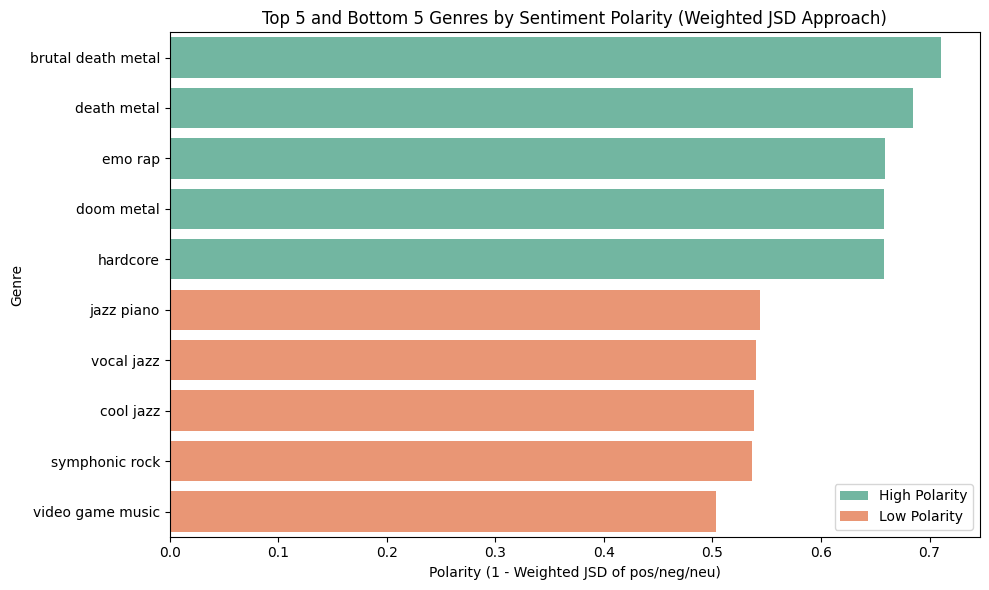

In [49]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
MIN_COMMENTS = 500
BINS = np.linspace(0, 1, 21)  # 20 bins between 0 and 1

# Ensure numeric
for col in ["vader_pos", "vader_neg", "vader_neu"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Drop missing
sent_data = data.dropna(subset=["vader_pos", "vader_neg", "vader_neu", "genre"])

results = []

# Compute weighted JSD-based polarity per genre
for genre, subset in sent_data.groupby("genre"):
    if len(subset) < MIN_COMMENTS:
        continue

    # Build histograms for pos/neg/neu
    pos_hist, _ = np.histogram(subset["vader_pos"], bins=BINS)
    neg_hist, _ = np.histogram(subset["vader_neg"], bins=BINS)
    neu_hist, _ = np.histogram(subset["vader_neu"], bins=BINS)

    if pos_hist.sum() > 0 and neg_hist.sum() > 0 and neu_hist.sum() > 0:
        pos_prob = pos_hist / pos_hist.sum()
        neg_prob = neg_hist / neg_hist.sum()
        neu_prob = neu_hist / neu_hist.sum()

        # Compute the three divergences
        jsd_pos_neg = jensenshannon(pos_prob, neg_prob, base=2) ** 2
        jsd_pos_neu = jensenshannon(pos_prob, neu_prob, base=2) ** 2
        jsd_neg_neu = jensenshannon(neg_prob, neu_prob, base=2) ** 2

        # Weighted score (lower divergence = higher polarity)
        weighted_jsd = 0.5 * jsd_pos_neg + 0.25 * jsd_pos_neu + 0.25 * jsd_neg_neu
        polarity = 1 - weighted_jsd

        results.append((genre, polarity, len(subset)))

polarity_df = pd.DataFrame(results, columns=["genre", "polarity", "n_comments"])
polarity_df = polarity_df.sort_values("polarity", ascending=False)  # reassign

top5 = polarity_df.head(5)   # now correct: top 5 highest
bottom5 = polarity_df.tail(5)  # now correct: bottom 5 lowest

print("Top 5 genres with highest polarity (weighted JSD):")
print(top5, "\n")
print("Bottom 5 genres with lowest polarity (weighted JSD):")
print(bottom5)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plot_df = pd.concat([top5, bottom5])

sns.barplot(
    data=plot_df,
    x="polarity", y="genre",
    hue=np.where(plot_df["polarity"] >= 0.6, "High Polarity", "Low Polarity"),
    dodge=False, palette="Set2"
)

plt.xlabel("Polarity (1 - Weighted JSD of pos/neg/neu)")
plt.ylabel("Genre")
plt.title("Top 5 and Bottom 5 Genres by Sentiment Polarity (Weighted JSD Approach)")
plt.tight_layout()
plt.savefig("plots/general_statistics/genre_sentiment_polarity_approach3.png", dpi=300)
plt.show()
polarity_df_approach3 = polarity_df

In [50]:
top_changes, bottom_changes = compute_rank_changes(polarity_df_approach1, polarity_df_approach3)

In [51]:
top_changes

,genre,rank1,rank2,delta_rank,n_comments_before,n_comments_after
0,brutal death metal,1,1,0,1116,1116
1,rap,2,7,5,1723,1723
2,experimental hip hop,3,15,12,1964,1964
3,noise,4,9,5,1045,1045
4,grime,5,24,19,1587,1587
5,death metal,6,2,-4,983,983
6,hardcore punk,7,17,10,1136,1136
7,deathcore,8,13,5,2033,2033
8,mathcore,9,33,24,1767,1767
9,emo rap,10,3,-7,2269,2269


In [52]:
bottom_changes

,genre,rank1,rank2,delta_rank,n_comments_before,n_comments_after
232,worship,233,225,-8,1926,1926
231,smooth jazz,232,224,-8,1995,1995
230,new age,231,207,-24,1102,1102
229,vocal jazz,230,230,0,1346,1346
228,world,229,223,-6,703,703
227,pop rock,228,216,-12,921,921
226,easy listening,227,221,-6,1487,1487
225,eurovision,226,220,-6,1720,1720
224,gospel,225,215,-10,592,592
223,celtic,224,228,4,1612,1612


In [53]:
top_changes, bottom_changes = compute_rank_changes(polarity_df_approach2, polarity_df_approach3)

In [54]:
top_changes

,genre,rank1,rank2,delta_rank,n_comments_before,n_comments_after
0,brutal death metal,1,1,0,695,1116
1,death metal,2,2,0,600,983
2,experimental hip hop,3,15,12,1042,1964
3,rap,4,7,3,872,1723
4,noise,5,9,4,559,1045
5,hardcore punk,6,17,11,597,1136
6,deathcore,7,13,6,1151,2033
7,grime,8,24,16,773,1587
8,mathcore,9,33,24,929,1767
9,emo rap,10,3,-7,1324,2269


In [55]:
bottom_changes

,genre,rank1,rank2,delta_rank,n_comments_before,n_comments_after
204,smooth jazz,205,224,19,1315,1995
203,worship,204,225,21,1379,1926
202,progressive trance,203,191,-12,1179,1991
201,talent show,202,175,-27,894,1398
200,celtic,201,228,27,970,1612
199,eurovision,200,220,20,1122,1720
198,easy listening,199,221,22,939,1487
197,blues,198,227,29,742,1256
196,motown,197,219,22,1261,2166
195,dream pop,196,211,15,854,1487
